<a href="https://colab.research.google.com/github/AndreyDyachkov/Data_analytics_with_Python_2/blob/main/AB-tests_health_insurance_products/AB_test_clinic_discount_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B test of a health insurance product modification. The effect of signed discounts with healthcare providers.

### Goal

Estimate the impact of discounts from healthcare providers on the average loss per unique policyholder per month.

### Tasks

1. Evaluate the fulfillment of conditions for discounts for each clinic. Condition: payment amount per month.
2. Choose healthcare facilities with discounts where the conditions were met.
3. Assess the change in the average payment per unique visitor per month for each health facility.
4. Compare the average loss per unique policyholder before the discount (4Q2022) and during the discount (1Q2023).
5. Calculate the statistical significance of the differences.

Data source : data on the amount of payment for each policy for each health facility per month; table with discounts and conditions.



### Results

Conditions for discounts were fulfilled at 8 clinics out of 21 clinics with which discounts had been signed. In 7 out of 8 health facilities with fulfilled conditions, an increase in the average payment per applicant was observed, however, the difference is not statistically significant. Only __clinic 701__ showed a statistically significant decrease in the average payment by 18%.

### Conclusion and recommendations

Signed discounts generally did not lead to a decrease in the average payment per client per month. Exception : __clinic_701__

Recommendations:
* check if there was an increase in prices at the beginning of 2023. Inflation may have corrected the impact of the discount because no statistically significant growth was found for these health facilities either.
* check if discounts were taken into account when paying healthcare providers.

### Imports and data processing

In [ ]:
import pandas as pd
import numpy as np

from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Data_analytics_with_Python_2/AB-tests_health_insurance_products/data/visits_medlpuprog_eng.xlsx')
df.head()

,YearMonthnumber,loss,MedLPU.RegionCodes.Region_group2,MedLPU.RegionCodes.Region3,MedLPU.Clinic_name4,POLCODE5
0,2023-02-01,1198,region_group_1,region_21,clinic_632,policy_15172
1,2023-02-01,1198,region_group_1,region_21,clinic_632,policy_15116
2,2023-01-01,1198,region_group_1,region_21,clinic_632,policy_15020
3,2023-03-01,1198,region_group_1,region_21,clinic_632,policy_15040
4,2023-03-01,1198,region_group_1,region_21,clinic_632,policy_14993


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43871 entries, 0 to 43870
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   YearMonthnumber                   43871 non-null  datetime64[ns]
 1   loss                              43871 non-null  int64         
 2   MedLPU.RegionCodes.Region_group2  43871 non-null  object        
 3   MedLPU.RegionCodes.Region3        43871 non-null  object        
 4   MedLPU.Clinic_name4               43871 non-null  object        
 5   POLCODE5                          43871 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 2.0+ MB


In [ ]:
df.columns = ['year_month', 'loss','region_group', 'region', 'clinic_name', 'policy_id']
df.head()

,year_month,loss,region_group,region,clinic_name,policy_id
0,2023-02-01,1198,region_group_1,region_21,clinic_632,policy_15172
1,2023-02-01,1198,region_group_1,region_21,clinic_632,policy_15116
2,2023-01-01,1198,region_group_1,region_21,clinic_632,policy_15020
3,2023-03-01,1198,region_group_1,region_21,clinic_632,policy_15040
4,2023-03-01,1198,region_group_1,region_21,clinic_632,policy_14993


Remove May 2023 as the data are not full

In [ ]:
df = df[df['year_month']<'2023-05-01']
df = df[df['loss']>0]
df.head()

,year_month,loss,region_group,region,clinic_name,policy_id
0,2023-02-01,1198,region_group_1,region_21,clinic_632,policy_15172
1,2023-02-01,1198,region_group_1,region_21,clinic_632,policy_15116
2,2023-01-01,1198,region_group_1,region_21,clinic_632,policy_15020
3,2023-03-01,1198,region_group_1,region_21,clinic_632,policy_15040
4,2023-03-01,1198,region_group_1,region_21,clinic_632,policy_14993


In [ ]:
df['year_month'] = pd.to_datetime(df['year_month']).dt.date

### EDA

In [ ]:
df.describe().apply(lambda s: s.apply('{0:.0f}'.format))

,loss
count,41315
mean,9412
std,23925
min,37
25%,2600
50%,5180
75%,10724
max,3714015


Presumably, it is a right-skewed distribution

Draw a histogram

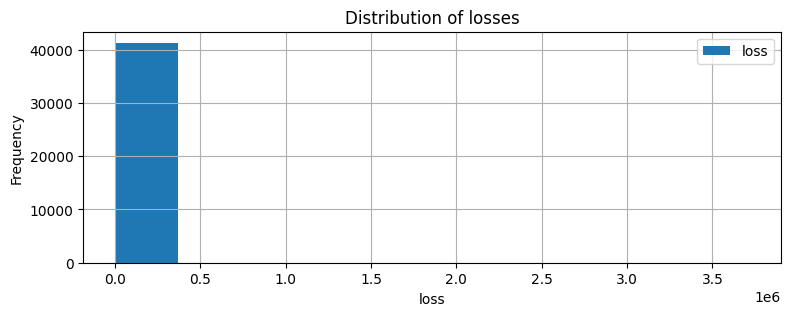

In [ ]:
df.plot(kind='hist', y='loss', bins=10, grid=True, figsize=(9,3), title='Distribution of losses')
plt.xlabel('loss')
plt.ylabel('Frequency')
plt.show()

and a boxplot

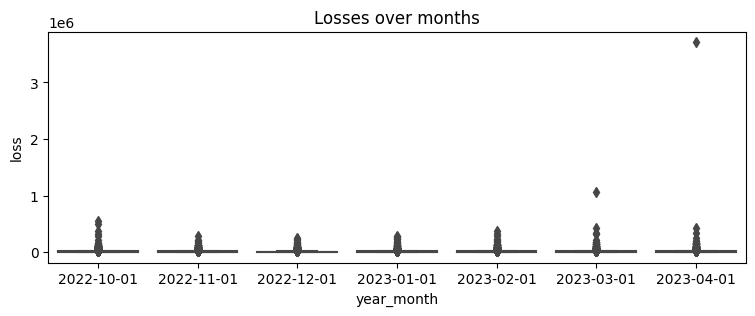

In [ ]:
plt.figure(figsize=(9,3))
sns.boxplot(x='year_month', y='loss', data=df.sort_values(by='year_month'), palette='rainbow')
plt.title('Losses over months')
plt.show()

They look not very informative. Let's remove outliers and redraw

In [ ]:
fixed_df = df[(df['loss'] < 150000)]

In [ ]:
fixed_df.describe()

,loss
count,41258.000000
mean,8995.028843
std,11596.583851
min,37.000000
25%,2600.000000
50%,5175.000000
75%,10689.500000
max,143062.000000


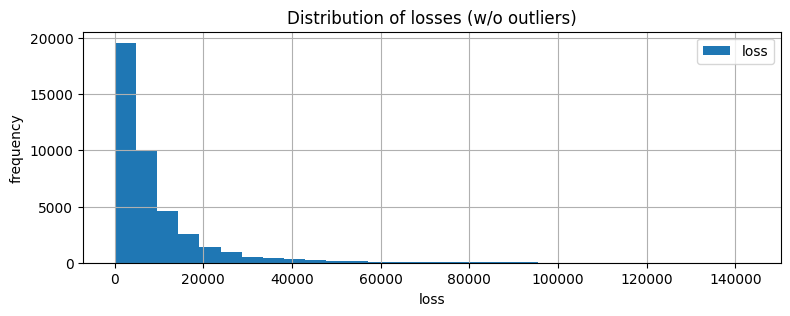

In [ ]:
fixed_df.plot(kind='hist', y='loss', bins=30, grid=True, figsize=(9,3), title='Distribution of losses (w/o outliers)')
plt.xlabel('loss')
plt.ylabel('frequency')
plt.show()

We got a lognormal distribution, typical for losses in the insurance industry

Let's check medians and quartiles on a boxplot

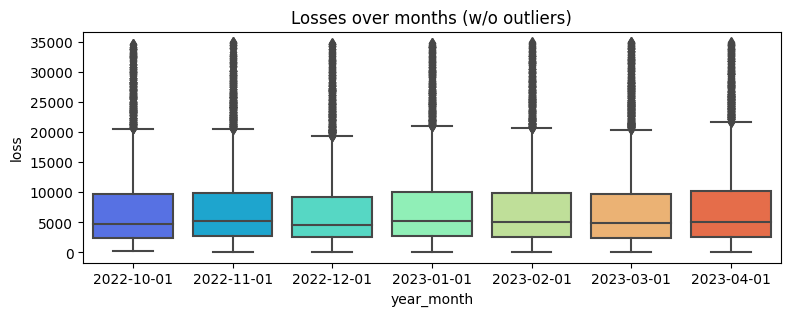

In [ ]:
plt.figure(figsize=(9,3))
plt.title('Losses over months (w/o outliers)')
sns.boxplot(x='year_month', y='loss', data=fixed_df[fixed_df['loss']<=35000].sort_values(by='year_month'), palette='rainbow')
plt.show()

The median doesn't seem to change a lot

Let's convert a lognormal distribution to normal (in order to apply parametric statistical tests)

In [ ]:
fixed_df['ln_loss'] = np.log(fixed_df['loss'])
fixed_df.head()

<ipython-input-14-6d33006d5698>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed_df['ln_loss'] = np.log(fixed_df['loss'])


,year_month,loss,region_group,region,clinic_name,policy_id,ln_loss
0,2023-02-01,1198,region_group_1,region_21,clinic_632,policy_15172,7.088409
1,2023-02-01,1198,region_group_1,region_21,clinic_632,policy_15116,7.088409
2,2023-01-01,1198,region_group_1,region_21,clinic_632,policy_15020,7.088409
3,2023-03-01,1198,region_group_1,region_21,clinic_632,policy_15040,7.088409
4,2023-03-01,1198,region_group_1,region_21,clinic_632,policy_14993,7.088409


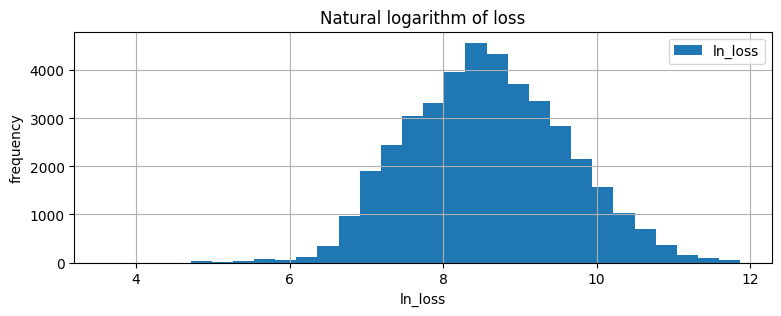

In [ ]:
fixed_df.plot(kind='hist', y='ln_loss', bins=30, grid=True, figsize=(9,3), title='Natural logarithm of loss')
plt.xlabel('ln_loss')
plt.ylabel('frequency')
plt.show()

We've got a perfect normal distribution

### Change average loss over months

##### data processing

In [ ]:
df_g1 = df.groupby(['year_month'], as_index=False).agg({'policy_id':'nunique','loss':'sum'})
df_g1['avg_per_uniq_policy'] = df_g1['loss'] / df_g1['policy_id']
df_g1

,year_month,policy_id,loss,avg_per_uniq_policy
0,2022-10-01,4854,54432377,11213.921920
1,2022-11-01,4826,54292948,11250.092831
2,2022-12-01,4834,50295574,10404.545718
3,2023-01-01,4320,47991088,11109.048148
4,2023-02-01,4941,55605823,11253.961344
5,2023-03-01,5654,61958160,10958.287938
6,2023-04-01,5324,64288671,12075.257513


In [ ]:
fixed_df_g1 = fixed_df.groupby(['year_month'], as_index=False).agg({'policy_id':'nunique','loss':'sum'})
fixed_df_g1['avg_per_uniq_policy'] = fixed_df_g1['loss'] / fixed_df_g1['policy_id']
fixed_df_g1

,year_month,policy_id,loss,avg_per_uniq_policy
0,2022-10-01,4851,51895968,10697.993816
1,2022-11-01,4825,53255248,11037.357098
2,2022-12-01,4832,49101768,10161.789735
3,2023-01-01,4315,46003014,10661.185168
4,2023-02-01,4937,53661260,10869.203970
5,2023-03-01,5652,58804833,10404.252123
6,2023-04-01,5317,58394809,10982.661087


In [ ]:
df_g1_1 = df.groupby(['year_month'], as_index=False)['loss'].median()
df_g1_1.rename(columns = {'loss':'median_loss'}, inplace = True)
df_g1_1

,year_month,median_loss
0,2022-10-01,5010.0
1,2022-11-01,5460.0
2,2022-12-01,4800.0
3,2023-01-01,5390.0
4,2023-02-01,5270.0
5,2023-03-01,5035.0
6,2023-04-01,5310.0


##### Visualization

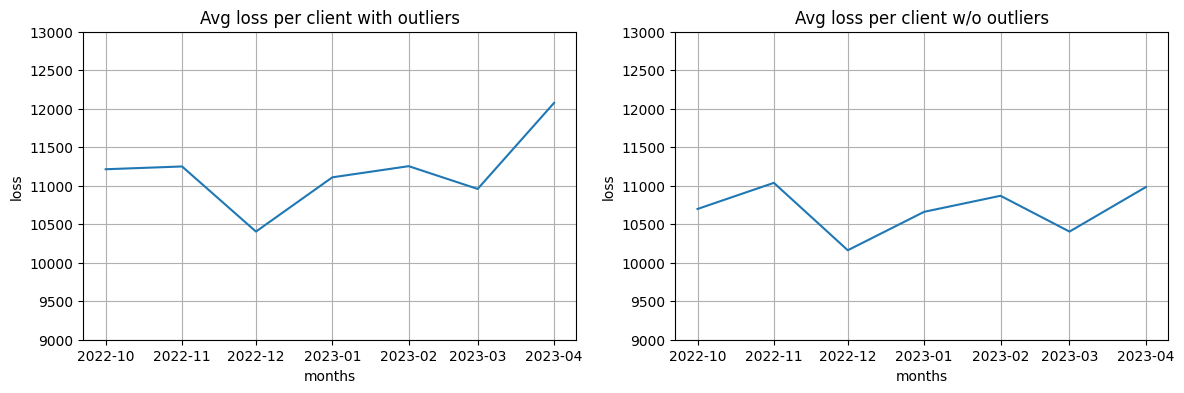

In [ ]:
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.plot(df_g1['year_month'], df_g1['avg_per_uniq_policy'])
plt.title('Avg loss per client with outliers')
plt.xlabel('months')
plt.ylabel('loss')
plt.ylim(9000, 13000)
plt.grid()

plt.subplot(1,2,2)
plt.plot(fixed_df_g1['year_month'], fixed_df_g1['avg_per_uniq_policy'])
plt.title('Avg loss per client w/o outliers')
plt.xlabel('months')
plt.ylabel('loss')
plt.ylim(9000, 13000)
plt.grid()
plt.show()

The fluctuations are smaller without outliers. Let's look at the median.

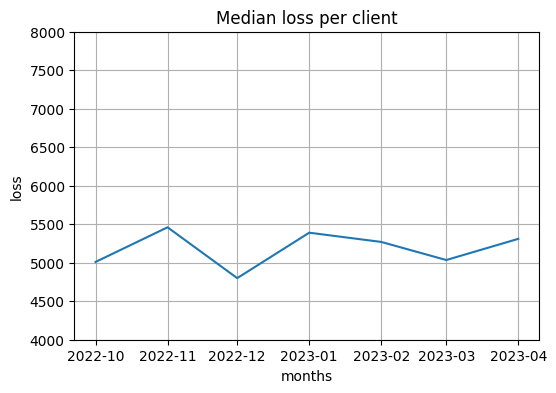

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(df_g1_1['year_month'], df_g1_1['median_loss'])
plt.title('Median loss per client')
plt.xlabel('months')
plt.ylabel('loss')
plt.ylim(4000, 8000)
plt.grid()

The average outlier-adjusted loss fluctuates within narrow limits, the median fluctuation is even smaller. So it is safe to compare two time periods, as we don't see any substantial trends.

### Top clinics by loss (for the reporting period 4Q2022-4m2023)

In [ ]:
df.groupby(['region_group','clinic_name'])['loss'].sum().sort_values(ascending=False).head(20)

region_group    clinic_name
region_group_1  clinic_257     27965335
                clinic_632     23907370
                clinic_824     21275536
                clinic_782     16880905
                clinic_62      13174745
region_group_3  clinic_701     11860688
region_group_1  clinic_490     10968036
                clinic_622      8760993
                clinic_5        8166983
                clinic_231      8111701
                clinic_543      7917441
region_group_3  clinic_318      7481808
region_group_1  clinic_195      6258663
                clinic_542      6052084
region_group_3  clinic_435      5181930
region_group_1  clinic_356      5057610
                clinic_716      4639638
region_group_3  clinic_198      4623995
region_group_1  clinic_377      4235690
                clinic_418      4190045
Name: loss, dtype: int64

### Check discount conditions

##### data processing

In [ ]:
discount = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Data_analytics_with_Python_2/AB-tests_health_insurance_products/data/discount_eng.xlsx')
discount.head()

,region_group,clinic_name,discount,condition
0,region_group_1,clinic_257,0.08,1.0
1,region_group_1,clinic_231,0.08,1.0
2,region_group_1,clinic_632,NaN,NaN
3,region_group_1,clinic_824,0.05,5500000.0
4,region_group_1,clinic_782,NaN,NaN


In [ ]:
discount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region_group  22 non-null     object 
 1   clinic_name   18 non-null     object 
 2   discount      14 non-null     float64
 3   condition     14 non-null     float64
dtypes: float64(2), object(2)
memory usage: 832.0+ bytes


Remove clinics w/o discounts

In [ ]:
discount.dropna(inplace=True)
discount

,region_group,clinic_name,discount,condition
0,region_group_1,clinic_257,0.08,1.0
1,region_group_1,clinic_231,0.08,1.0
3,region_group_1,clinic_824,0.05,5500000.0
5,region_group_1,clinic_62,0.05,1200000.0
6,region_group_1,clinic_543,0.05,2000000.0
7,region_group_1,clinic_542,0.05,2000000.0
8,region_group_1,clinic_490,0.10,300000.0
11,region_group_1,clinic_356,0.05,1000000.0
12,region_group_1,clinic_300,0.05,1000000.0
15,region_group_1,clinic_333,0.05,1000000.0


Group the main df to get sum of losses

In [ ]:
df_loss_by_month = df.groupby(['year_month',	'region_group',	'region',	'clinic_name'], as_index=False)['loss'].sum()
df_loss_by_month

,year_month,region_group,region,clinic_name,loss
0,2022-10-01,region_group_1,region_21,clinic_10,126400
1,2022-10-01,region_group_1,region_21,clinic_100,27535
2,2022-10-01,region_group_1,region_21,clinic_11,141755
3,2022-10-01,region_group_1,region_21,clinic_110,20670
4,2022-10-01,region_group_1,region_21,clinic_116,140749
...,...,...,...,...,...
3562,2023-04-01,region_group_3,region_40,clinic_701,1830181
3563,2023-04-01,region_group_3,region_40,clinic_759,15600
3564,2023-04-01,region_group_3,region_40,clinic_789,20112
3565,2023-04-01,region_group_3,region_40,clinic_8,63570


Remove clinics w/o discounts

In [ ]:
merged_df = pd.merge(df_loss_by_month, discount, how='inner', on=['region_group', 'clinic_name'])
merged_df

,year_month,region_group,region,clinic_name,loss,discount,condition
0,2022-10-01,region_group_1,region_21,clinic_231,802788,0.08,1.0
1,2022-11-01,region_group_1,region_21,clinic_231,1275669,0.08,1.0
2,2022-12-01,region_group_1,region_21,clinic_231,875375,0.08,1.0
3,2023-01-01,region_group_1,region_21,clinic_231,869622,0.08,1.0
4,2023-02-01,region_group_1,region_21,clinic_231,1656285,0.08,1.0
...,...,...,...,...,...,...,...
93,2022-12-01,region_group_3,region_40,clinic_701,1895492,0.05,1600000.0
94,2023-01-01,region_group_3,region_40,clinic_701,1216213,0.05,1600000.0
95,2023-02-01,region_group_3,region_40,clinic_701,1370740,0.05,1600000.0
96,2023-03-01,region_group_3,region_40,clinic_701,1929960,0.05,1600000.0


Check for conditions met

In [ ]:
merged_df['fullfill_condition'] = merged_df['loss'] >= merged_df['condition']
merged_df

,year_month,region_group,region,clinic_name,loss,discount,condition,fullfill_condition
0,2022-10-01,region_group_1,region_21,clinic_231,802788,0.08,1.0,True
1,2022-11-01,region_group_1,region_21,clinic_231,1275669,0.08,1.0,True
2,2022-12-01,region_group_1,region_21,clinic_231,875375,0.08,1.0,True
3,2023-01-01,region_group_1,region_21,clinic_231,869622,0.08,1.0,True
4,2023-02-01,region_group_1,region_21,clinic_231,1656285,0.08,1.0,True
...,...,...,...,...,...,...,...,...
93,2022-12-01,region_group_3,region_40,clinic_701,1895492,0.05,1600000.0,True
94,2023-01-01,region_group_3,region_40,clinic_701,1216213,0.05,1600000.0,False
95,2023-02-01,region_group_3,region_40,clinic_701,1370740,0.05,1600000.0,False
96,2023-03-01,region_group_3,region_40,clinic_701,1929960,0.05,1600000.0,True


In [ ]:
df_pivoted1 = merged_df.pivot_table(index=['region_group',	'clinic_name'], columns='year_month', values='fullfill_condition')

In [ ]:
df_pivoted1

year_month                  2022-10-01  2022-11-01  2022-12-01  2023-01-01  \
region_group   clinic_name                                                   
region_group_1 clinic_231          1.0         1.0         1.0         1.0   
               clinic_257          1.0         1.0         1.0         1.0   
               clinic_300          0.0         0.0         0.0         0.0   
               clinic_333          0.0         0.0         0.0         0.0   
               clinic_356          0.0         0.0         0.0         0.0   
               clinic_490          1.0         1.0         1.0         1.0   
               clinic_542          0.0         0.0         0.0         0.0   
               clinic_543          0.0         0.0         0.0         0.0   
               clinic_62           1.0         1.0         1.0         1.0   
               clinic_824          0.0         0.0         0.0         0.0   
region_group_3 clinic_198          1.0         1.0         1.0         1.0   
               clinic_318          1.0         0.0         1.0         1.0   
               clinic_435          0.0         0.0         0.0         0.0   
               clinic_701          1.0         1.0         1.0         0.0   

year_month                  2023-02-01  2023-03-01  2023-04-01  
region_group   clinic_name                                      
region_group_1 clinic_231          1.0         1.0         1.0  
               clinic_257          1.0         1.0         1.0  
               clinic_300          0.0         0.0         0.0  
               clinic_333          0.0         1.0         0.0  
               clinic_356          0.0         0.0         0.0  
               clinic_490          1.0         1.0         1.0  
               clinic_542          0.0         0.0         0.0  
               clinic_543          0.0         0.0         0.0  
               clinic_62           1.0         1.0         1.0  
               clinic_824          0.0         0.0         0.0  
region_group_3 clinic_198          1.0         1.0         1.0  
               clinic_318          1.0         0.0         1.0  
               clinic_435          0.0         0.0         0.0  
               clinic_701          0.0         1.0         1.0

##### Visualization

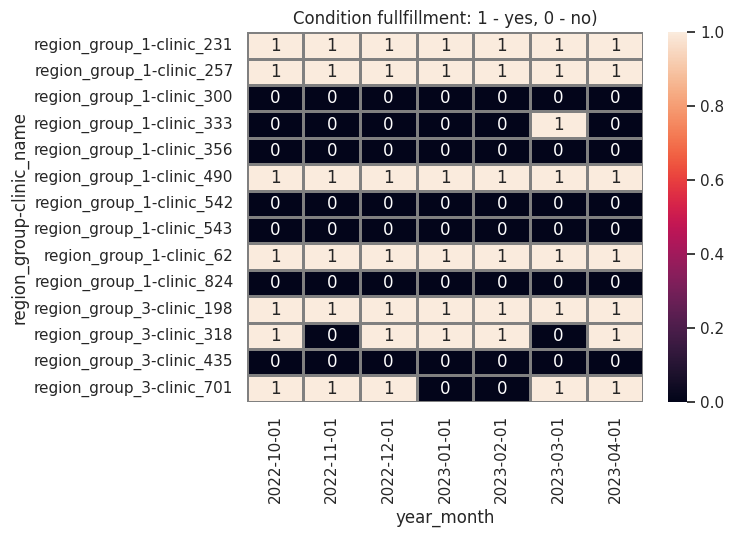

In [ ]:
sns.set(style='white')
plt.title('Condition fullfillment: 1 - yes, 0 - no)')
sns.heatmap(df_pivoted1, annot=True, linewidths=1, linecolor='gray');

The discounts were signed at the beginning of 2023. So the conditions are met at least a month  in 8 clinics. The list of the clinis:

In [ ]:
clinics_to_check = merged_df[(merged_df['fullfill_condition']) & (merged_df['year_month']>pd.to_datetime("2022-12-01").date())][['region_group','clinic_name']]
clinics_to_check.drop_duplicates(inplace=True)
clinics_to_check


,region_group,clinic_name
3,region_group_1,clinic_231
10,region_group_1,clinic_257
31,region_group_1,clinic_490
52,region_group_1,clinic_62
68,region_group_1,clinic_333
73,region_group_3,clinic_198
80,region_group_3,clinic_318
96,region_group_3,clinic_701


### Evaluation of the average loss for clinics with a working discount

Estimate on a dataset cleaned of outliers

##### data processing

In [ ]:
fixed_df_g2 = fixed_df.groupby(['year_month','region_group',	'region',	'clinic_name'], as_index=False).agg(
    avg_per_uniq_policy=('loss', np.mean),
    median_per_uniq_policy=('loss', np.median),
    avg_per_uniq_policy_ln=('ln_loss', np.mean))

fixed_df_g2.head()

,year_month,region_group,region,clinic_name,avg_per_uniq_policy,median_per_uniq_policy,avg_per_uniq_policy_ln
0,2022-10-01,region_group_1,region_21,clinic_10,5495.652174,4700.0,8.431676
1,2022-10-01,region_group_1,region_21,clinic_100,27535.000000,27535.0,10.223213
2,2022-10-01,region_group_1,region_21,clinic_11,10904.230769,4290.0,8.691441
3,2022-10-01,region_group_1,region_21,clinic_110,20670.000000,20670.0,9.936439
4,2022-10-01,region_group_1,region_21,clinic_116,28149.800000,8000.0,9.551836


Get the target clinics from the main dataset

In [ ]:
fixed_df_g2_clinics_to_check = fixed_df_g2.merge(clinics_to_check, how='inner', on=['region_group','clinic_name'])
fixed_df_g2_clinics_to_check.head()

,year_month,region_group,region,clinic_name,avg_per_uniq_policy,median_per_uniq_policy,avg_per_uniq_policy_ln
0,2022-10-01,region_group_1,region_21,clinic_231,18245.181818,9550.0,9.272988
1,2022-11-01,region_group_1,region_21,clinic_231,18926.603448,12238.0,9.488732
2,2022-12-01,region_group_1,region_21,clinic_231,14350.409836,7880.0,9.070784
3,2023-01-01,region_group_1,region_21,clinic_231,17051.411765,13890.0,9.417141
4,2023-02-01,region_group_1,region_21,clinic_231,18274.442857,10150.0,9.290253


##### Visualization: the average loss for clinics with a working discount

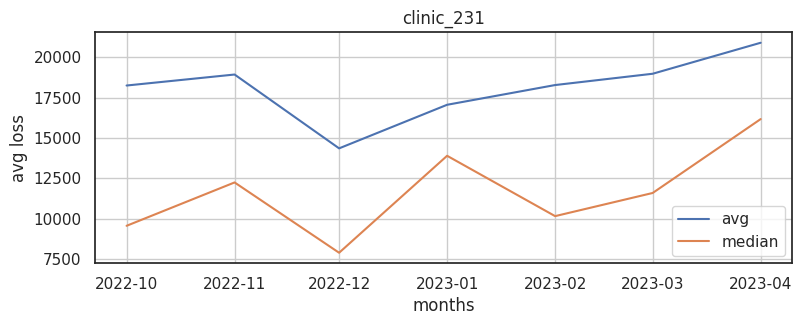

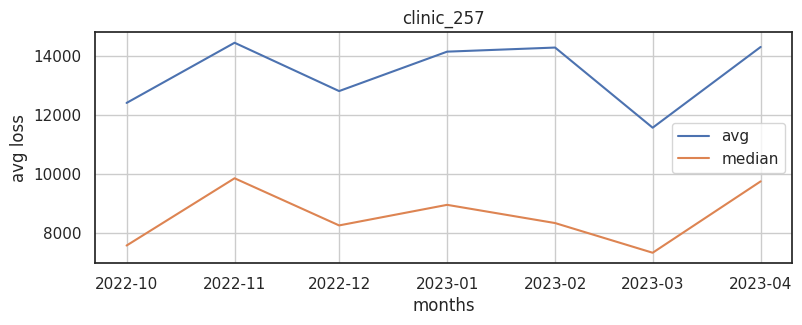

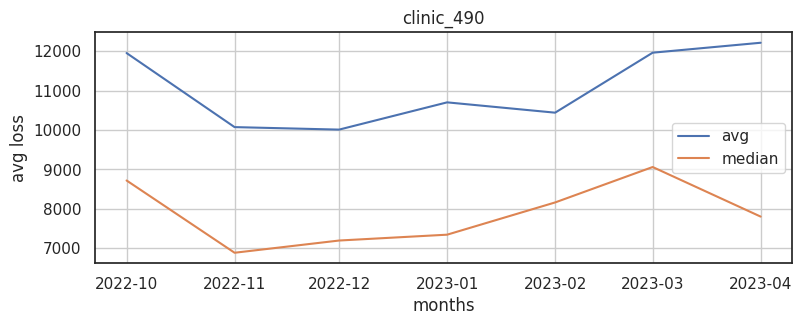

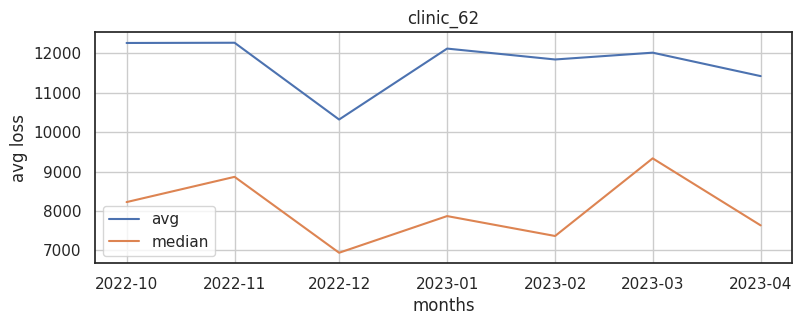

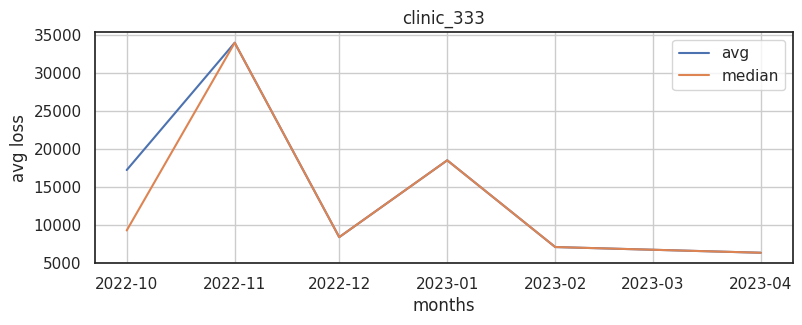

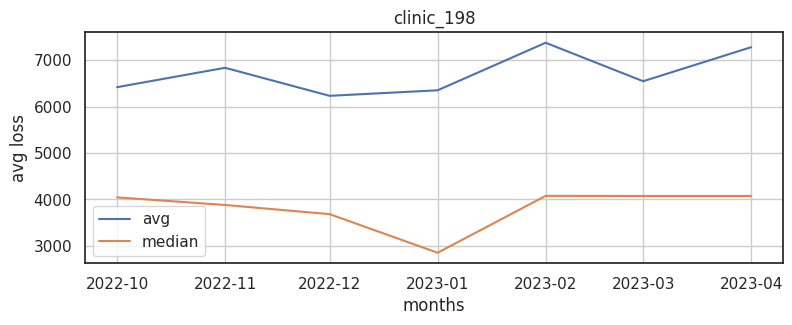

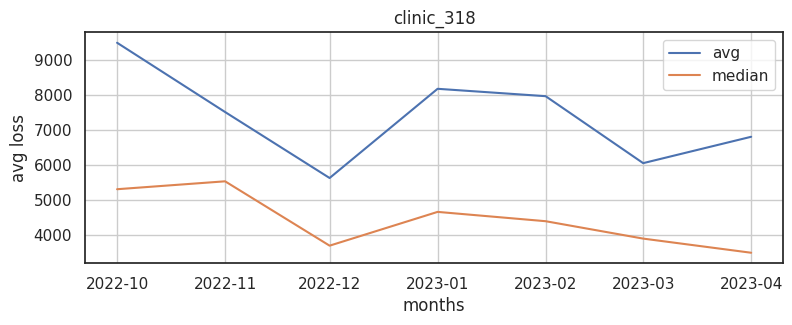

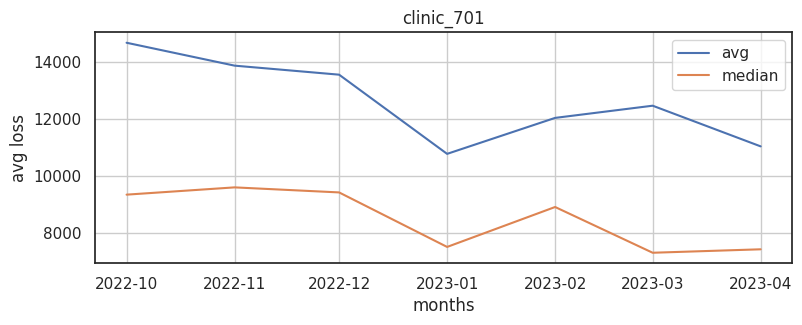

In [ ]:
for clinic_name in clinics_to_check['clinic_name']:

  x = fixed_df_g2_clinics_to_check[fixed_df_g2_clinics_to_check['clinic_name']==clinic_name]['year_month']
  y1 = fixed_df_g2_clinics_to_check[fixed_df_g2_clinics_to_check['clinic_name']==clinic_name]['avg_per_uniq_policy']
  y2 = fixed_df_g2_clinics_to_check[fixed_df_g2_clinics_to_check['clinic_name']==clinic_name]['median_per_uniq_policy']
  plt.figure(figsize=(9,3))
  plt.plot(x, y1, label='avg')
  plt.plot(x, y2, label='median')
  plt.title(clinic_name)
  plt.legend()
  plt.xlabel('months')
  plt.ylabel('avg loss')
  #plt.ylim(5000, 25000)
  plt.grid()
  plt.show()

It looks like the average loss per policyholder and median decreased only in clinic 701. Other clinics show an increase.

### t-tests

We compare 4Q2022 and 1Q2023. The distribution is lognormal, so let's run t-tests on the natural logarithm of the loss variable. The null hypothesis is that the average loss didn't change after the discount.

##### data processing

In [ ]:
df_for_test = fixed_df[(fixed_df['year_month']<pd.to_datetime("2023-04-01").date())].merge(clinics_to_check, how='inner', on=['region_group','clinic_name'])
df_for_test.head()

,year_month,loss,region_group,region,clinic_name,policy_id,ln_loss
0,2023-01-01,19940,region_group_1,region_21,clinic_257,policy_3866,9.900483
1,2023-01-01,24561,region_group_1,region_21,clinic_257,policy_15216,10.108915
2,2023-01-01,41080,region_group_1,region_21,clinic_257,policy_11271,10.623277
3,2023-01-01,6100,region_group_1,region_21,clinic_257,policy_14844,8.716044
4,2023-01-01,23802,region_group_1,region_21,clinic_257,policy_10887,10.077525


Define function to draw histograms for each clinic

In [ ]:
def year_func(month):
    if month < pd.to_datetime('2023-01-01').date():
      return '4Q2022'
    else:
      return '1Q2023'

df_for_test['group'] = df_for_test['year_month'].apply(year_func)

##### Histograms of loss logarithm

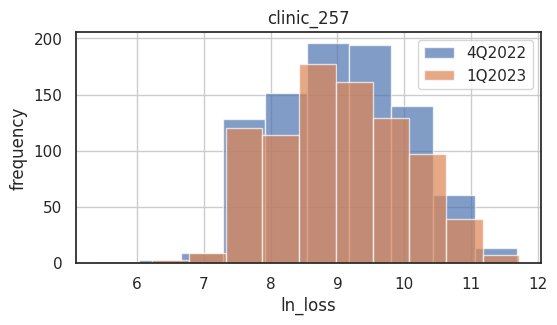

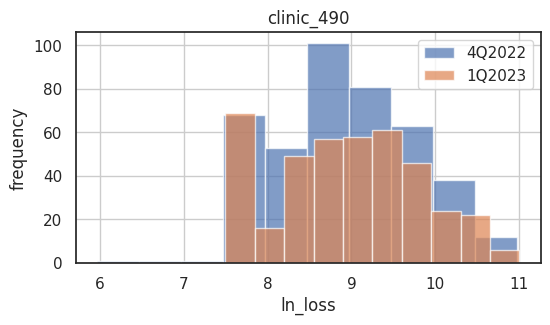

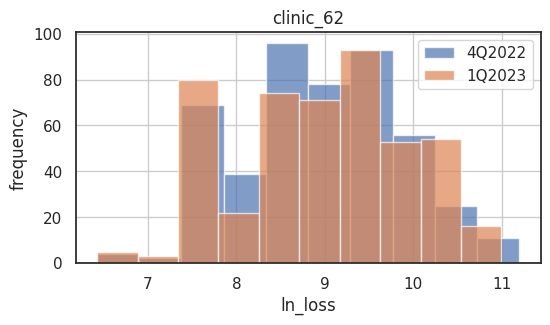

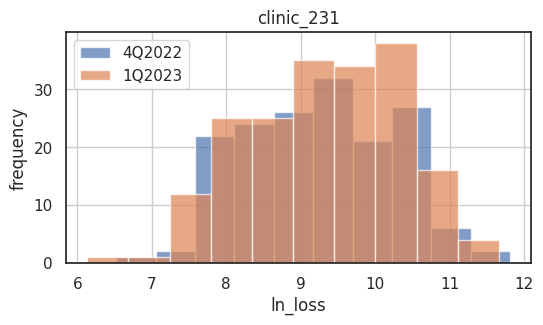

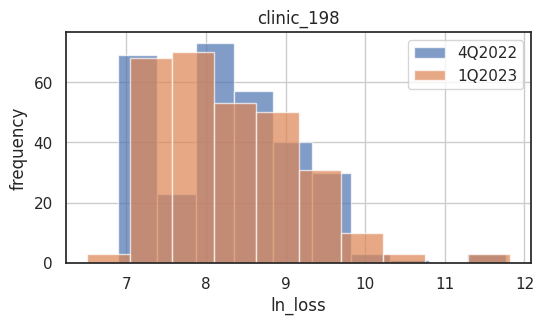

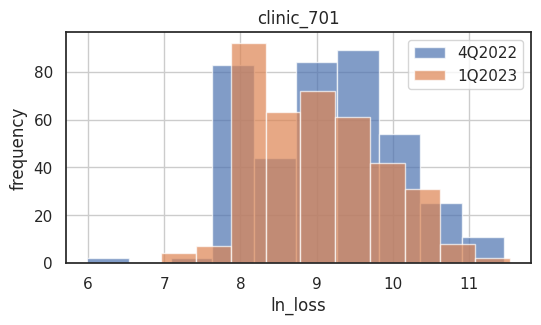

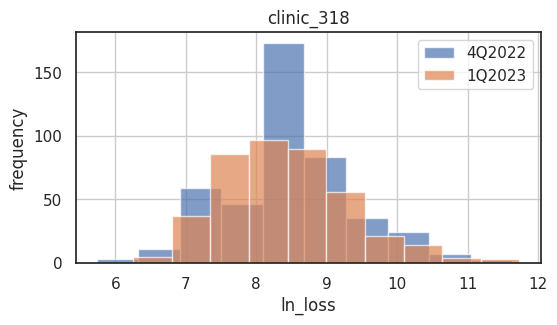

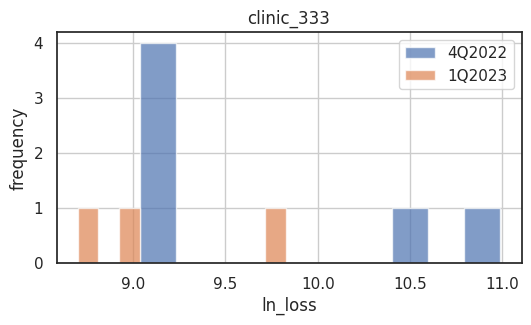

In [ ]:
for clinic in df_for_test['clinic_name'].unique():
  plt.figure(figsize=(6, 3))
  group1 = df_for_test[(df_for_test['clinic_name']==clinic)&(df_for_test['group']=='4Q2022')]['ln_loss']
  group2 = df_for_test[(df_for_test['clinic_name']==clinic)&(df_for_test['group']=='1Q2023')]['ln_loss']
  plt.hist(group1, label = '4Q2022', bins=10, alpha=0.7)
  plt.hist(group2, label = '1Q2023', bins=10, alpha=0.7)
  plt.title(clinic)
  plt.grid(True)
  plt.legend()
  plt.xlabel('ln_loss')
  plt.ylabel('frequency')
  plt.show()

There is not much difference between the two periods. Let's run a t-test with alpha = 0.05

##### t-test

Make a function to conduct all the test at once

In [ ]:
def test_func(clinic,group1, group2, alpha):
  results = st.ttest_ind(group1, group2, equal_var=True)
  #print(clinic)
  print('p-value:', round(results.pvalue,4))
  print('t-statistic:', round(results.statistic,4))

  if results.pvalue < alpha:
    print("Reject H0")
  else:
    print("No significant difference. H0 is true")

In [ ]:
alpha = 0.05

for clinic in df_for_test['clinic_name'].unique():
  group1 = df_for_test[(df_for_test['clinic_name']==clinic)&(df_for_test['group']=='4Q2022')]['ln_loss']
  group2 = df_for_test[(df_for_test['clinic_name']==clinic)&(df_for_test['group']=='1Q2023')]['ln_loss']
  group1_for_diff = df_for_test[(df_for_test['clinic_name']==clinic)&(df_for_test['group']=='4Q2022')]['loss']
  group2_for_diff = df_for_test[(df_for_test['clinic_name']==clinic)&(df_for_test['group']=='1Q2023')]['loss']
  diff = group2_for_diff.mean() - group1_for_diff.mean()
  diff_percentage = group1_for_diff.mean() / group2_for_diff.mean() -1
  print(clinic)
  print('diff in means:',diff,'(',diff_percentage,')')
  test_func(clinic,group1, group2, alpha)
  print()

clinic_257
diff in means: 80.84030791054829 ( -0.0060717483943424355 )
p-value: 0.9756
t-statistic: 0.0306
No significant difference. H0 is true

clinic_490
diff in means: 355.6295802330478 ( -0.03214405916563734 )
p-value: 0.3998
t-statistic: -0.8424
No significant difference. H0 is true

clinic_62
diff in means: 421.17047530556556 ( -0.03512734689041186 )
p-value: 0.7877
t-statistic: -0.2694
No significant difference. H0 is true

clinic_231
diff in means: 1174.4411075065036 ( -0.06451364081674071 )
p-value: 0.4377
t-statistic: -0.777
No significant difference. H0 is true

clinic_198
diff in means: 247.62806146490584 ( -0.03672999334631799 )
p-value: 0.9641
t-statistic: 0.045
No significant difference. H0 is true

clinic_701
diff in means: -2169.513819863396 ( 0.18347802563118165 )
p-value: 0.0214
t-statistic: 2.3048
Reject H0

clinic_318
diff in means: 154.253034832941 ( -0.021130833068867094 )
p-value: 0.7332
t-statistic: 0.341
No significant difference. H0 is true

clinic_333
diff 

We found only one clinic with statistically significant difference: clinic 701. the average loss dropped by 18%.